# Mass Balance Components

Here we explore components from EMY/KMR model results. 

In [2]:
import PDD
import calendar
import numpy as np
import pymc3 as pm 
import arviz as az
import pandas as pd
import xarray as xr
from numpy import random
from scipy import linalg as LA
import matplotlib.pyplot as plt 

# Set global matplotlib style parameters
plt.rcParams.update({'text.usetex': True, 
                     'animation.html': 'jshtml', 
                     'figure.facecolor': 'w', 
                     'savefig.bbox':'tight'})


__Load Katie's Net Balance Results__: 

In [3]:
nc_fp = "../MB_tune/notebooks/Young_etal_2020_Delta_T_-0.9_C.nc"

with xr.open_dataset(nc_fp) as MB_new: 
    DOY_mean = MB_new.temp.groupby("time.dayofyear").mean()
    DOY_std  = MB_new.temp.groupby("time.dayofyear").std()

__Daily Distributed Temperatre Arrays__: 

In [4]:
# create time coordinate array
time = pd.date_range("2007-01-01", "2018-12-31", freq='D')

fp = "/Users/andrewnolan/Downloads/Katies_MB_model_runs/DailyDistributedTemp{}.npy"

temps = []

for year in np.arange(2007,2019): 
    year_fp = fp.format(year)
    
    temps.append(np.load(year_fp))

coords={
    "lon"  : (["x", "y"], MB_new.lon.values),
    "lat"  : (["x", "y"], MB_new.lat.values),
    "time" : time,     
}

ds = xr.Dataset( {
    
"Temp" : xr.DataArray(
                    data   = np.concatenate(temps, axis=0),
                    dims   = ["time", "x", "y"],
                    coords = coords, 
                    attrs  = {'_FillValue': np.nan, 
                              'units'     : 'C'
                        }), 
"Elevation" : xr.DataArray(
                data   = MB_new.Elevation.values,
                dims   = ["x", "y"],
                coords = {key: coords[key] for key in coords.keys() if key != 'time'}, 
                attrs  = {'_FillValue': np.nan, 
                          'units'     : 'm a.s.l.'
                    })},
)

# delete the list of numpy arrays to save memory
del temps

Space-time plot of mean-daily-temperature as a function of elevation

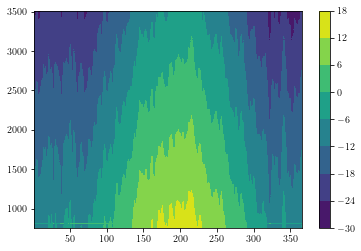

In [5]:
# Find the indexes of valid glacier gridcells
idxs = ds.Elevation.stack(z=('x', 'y')).dropna('z').z.values
# Find the elevation at valid gridcells
elev = ds.Elevation.stack(z=('x', 'y')).dropna('z').values
# Sort indexes by elevation 
idxs = idxs[np.argsort(elev)]
# select valid gridcells sorted by elevation and calc daily average of all fields 
valid = ds.stack(z=('x', 'y')).sel(z=idxs).groupby('time.dayofyear').mean()

# Make the space-time plot
fig, ax = plt.subplots()
im = ax.contourf(valid.dayofyear.to_numpy(),
                 valid.Elevation.isel(dayofyear=0),              
                 valid.Temp.T)
fig.colorbar(im)

Lets see how variable the air temperaure lapse rate is, on a montly timescale, from the average monthly fileds over the 11 years the model is run. The lapse rate is assumed to linear with respect to elevation (a valid assumption based on visual inspection of the data). 

In [6]:
# Sample some of the elevation
Z = ds.stack(z=('x', 'y')).sel(z=idxs).Elevation[::100].values
# create design matrix 
M = Z[:, np.newaxis]**[0,1]

# Find the montly average temperature 
T_montly = ds.stack(z=('x', 'y')).sel(z=idxs).groupby('time.month').mean()

ΔPΔz_mean = 0.0 
for month in T_montly.month: 
    # Select the monthly data
    T = T_montly.sel(month=month).Temp[::100].values
    # fit a first order polynomial (line) to temp dat
    p, res, rnk, s = LA.lstsq(M, T)
    # Get the string abbrv for the month
    month_abr = list(calendar.month_abbr)[int(month)]
                                              
    print(f"{month_abr} ΔPΔz = {p[1]:.2e} K/km")
    
    ΔPΔz_mean += p[1]

print("-"*20)
print(f"Avg ΔPΔz = {ΔPΔz_mean/12:.2e}  K/km")

Jan ΔPΔz = -5.91e-03 K/km
Feb ΔPΔz = -5.85e-03 K/km
Mar ΔPΔz = -6.17e-03 K/km
Apr ΔPΔz = -6.53e-03 K/km
May ΔPΔz = -6.73e-03 K/km
Jun ΔPΔz = -6.94e-03 K/km
Jul ΔPΔz = -6.60e-03 K/km
Aug ΔPΔz = -6.44e-03 K/km
Sep ΔPΔz = -6.33e-03 K/km
Oct ΔPΔz = -6.31e-03 K/km
Nov ΔPΔz = -6.16e-03 K/km
Dec ΔPΔz = -6.10e-03 K/km
--------------------
Avg ΔPΔz = -6.34e-03  K/km


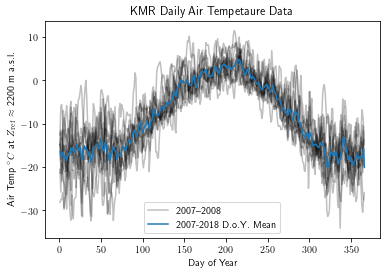

In [7]:
fig, ax = plt.subplots()

# ax.fill_between(DOY_mean.dayofyear, 
#                 DOY_mean-2*DOY_std, DOY_mean+2*DOY_std, 
#                 alpha=0.25, color='tab:orange', 
#                 label='2$\sigma$')

# ax.fill_between(DOY_mean.dayofyear, 
#                 DOY_mean-DOY_std, DOY_mean+DOY_std, 
#                 alpha=0.75, color='tab:orange',
#                 label='$\sigma$')

for year in np.arange(2007, 2019):
    yearly = MB_new.isel(time=MB_new.time.dt.year==year)
    
    if year == 2018: 
        ax.plot(yearly.time.dt.dayofyear, yearly.temp, 
                color='k', alpha=0.25, label='2007--2008')
    else: 
        ax.plot(yearly.time.dt.dayofyear, yearly.temp, color='k', alpha=0.25)
        
ax.plot(DOY_mean.dayofyear, DOY_mean, color='tab:blue', 
         label='2007-2018 D.o.Y. Mean')

ax.legend(loc=8)

ax.set_title('KMR Daily Air Tempetaure Data')
ax.set_xlabel('Day of Year')
ax.set_ylabel(r'Air Temp $^\circ C$ at $Z_{\rm ref} \approx $ 2200 m a.s.l.')

fig.savefig('./figs/KMR_daily_air_temp.png', dpi=300)

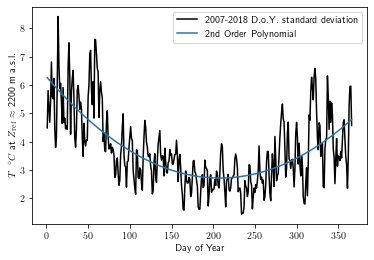

In [8]:
fig, ax = plt.subplots()

ax.plot(DOY_mean.dayofyear, DOY_std, color='k', 
         label='2007-2018 D.o.Y. standard deviation')

p = np.polyfit(DOY_mean.dayofyear, DOY_std, 2)

ax.plot(DOY_mean.dayofyear, 
        np.polyval(p, DOY_mean.dayofyear),
        label='2nd Order Polynomial')
    

ax.legend()
ax.set_xlabel('Day of Year')
ax.set_ylabel(r'$T \;\; ^\circ C$ at $Z_{\rm ref} \approx $ 2200 m a.s.l.')

fig.savefig('./figs/KMR_daily_std_of_air_temp.png', dpi=300)

In [9]:
p = np.polyfit(DOY_mean.dayofyear, DOY_std, 2)
fancy_std = np.polyval(p, DOY_mean.dayofyear)

## Parameter Estimation 

Let us now use non-linear least squares to back out the unknown air temperature model parameters from the KMR data. Our forward model is of the form: 
$$
\begin{equation}
    T(d,z) = \alpha \cos\left( \frac{2 \pi \left(d - \hat{T} \right) }{365} \right) + T_{\rm ma} + (z - z_{\rm ref}) \frac{d T}{dz} ,
\end{equation} 
$$

where:
- $\color{blue}{ \alpha}$ is the annual air temperature amplitude (K), 
- $\color{blue}{ T_{\rm ma}}$ is the mean annual air temperature at reference elevation $z_{\rm ref}$ (K) ,
- $\color{green}{ \frac{d T}{dz}}$ is the atmospheric lapse rate (K m$^{-1}$).
- $\color{blue}{ \hat{T}}$ is the DOY of air temperature peak (d)

In [10]:
from scipy import optimize

class AirTemp:
    
    def __init__(self, T_obs): 
        
        if T_obs.size in [365, 366]: 
            self.T_obs = T_obs
            self.doy   = np.arange(1,T_obs.size+1)
        else: 
            raise ValueError('T_obs must be of size 365 or 366')
        
    def forward(self, p): 
        T = p[0] * np.cos(2 * np.pi * (self.doy - p[1]) / self.doy.size) + p[2] 
        return T

    def __cost(self, p): 
        return self.forward(p) - self.T_obs
    
    def fit(self, p0, loss='soft_l1'): 
        res_lsq = optimize.least_squares(self.__cost, p0, loss=loss)
        return res_lsq

In [11]:
Temp_model = AirTemp(DOY_mean)
res_lstq   = Temp_model.fit(p0=[10,193,-8])
predicted  = Temp_model.forward(res_lstq.x)

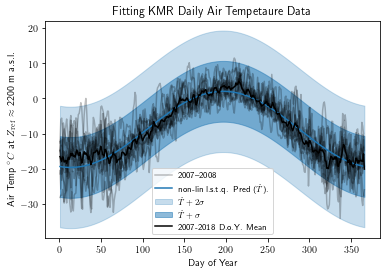

In [12]:
KMR_std = float(MB_new.temp.std())

fig, ax = plt.subplots()

for year in np.arange(2007, 2019):
    yearly = MB_new.isel(time=MB_new.time.dt.year==year)
    
    if year == 2018: 
        ax.plot(yearly.time.dt.dayofyear, yearly.temp, 
                color='k', alpha=0.25, label='2007--2008')
    else: 
        ax.plot(yearly.time.dt.dayofyear, yearly.temp, color='k', alpha=0.25)
            
ax.plot(DOY_mean.dayofyear, predicted, 
        label=r'non-lin l.s.t.q. Pred ($\hat T$).')

ax.fill_between(DOY_mean.dayofyear, 
                predicted-2*KMR_std, 
                predicted+2*KMR_std, 
                alpha=0.25, color='tab:blue', 
                label='$\hat T + 2 \sigma$')

ax.fill_between(DOY_mean.dayofyear, 
                predicted-KMR_std, 
                predicted+KMR_std,
                alpha=0.5, color='tab:blue',
                label='$\hat T + \sigma$')
    
ax.plot(DOY_mean.dayofyear, DOY_mean, color='k', 
         label='2007-2018 D.o.Y. Mean')

ax.legend(fontsize='small')

ax.set_title('Fitting KMR Daily Air Tempetaure Data')
ax.set_xlabel('Day of Year')
ax.set_ylabel(r'Air Temp $^\circ C$ at $Z_{\rm ref} \approx $ 2200 m a.s.l.')

fig.savefig('./figs/FIT_KMR_daily_air_temp.png', dpi=300)

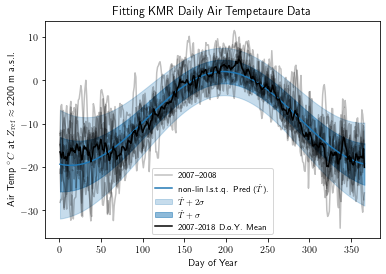

In [13]:
fig, ax = plt.subplots()

for year in np.arange(2007, 2019):
    yearly = MB_new.isel(time=MB_new.time.dt.year==year)
    
    if year == 2018: 
        ax.plot(yearly.time.dt.dayofyear, yearly.temp, 
                color='k', alpha=0.25, label='2007--2008')
    else: 
        ax.plot(yearly.time.dt.dayofyear, yearly.temp, color='k', alpha=0.25)
            
ax.plot(DOY_mean.dayofyear, predicted, 
        label=r'non-lin l.s.t.q. Pred ($\hat T$).')

ax.fill_between(DOY_mean.dayofyear, 
                predicted-2*fancy_std, predicted+2*fancy_std, 
                alpha=0.25, color='tab:blue', 
                label='$\hat T + 2 \sigma$')

ax.fill_between(DOY_mean.dayofyear, 
                predicted-fancy_std, predicted+fancy_std,
                alpha=0.5, color='tab:blue',
                label='$\hat T + \sigma$')
    
ax.plot(DOY_mean.dayofyear, DOY_mean, color='k', 
         label='2007-2018 D.o.Y. Mean')

ax.legend(fontsize='small')

ax.set_title('Fitting KMR Daily Air Tempetaure Data')
ax.set_xlabel('Day of Year')
ax.set_ylabel(r'Air Temp $^\circ C$ at $Z_{\rm ref} \approx $ 2200 m a.s.l.')

fig.savefig('./figs/FIT_wfancystd_KMR_daily_air_temp.png', dpi=300)